#### Dataset and its structure
1. We can use Urban Sound Classification ( https://urbansounddataset.weebly.com/ ) dataset which is quite popular.
2. I personally used UrbanSound8K dataset (https://urbansounddataset.weebly.com/urbansound8k.html).
3. For UrbanSound8K dataset, it can be downloaded using the following link ( https://goo.gl/8hY5ER ). It downloads a compressed tar file of size around 6GB.
4. On extracting it, it contains two folders named 'audio' and 'metadata'.
5. Audio folder contains 10 folders with name fold1, fold2 and so on, each having approximately 800 audio files of 4s each.
6. Metadata folder contains a .csv file having various columns such as file_id, label, class_id corresponding to label, salience etc.
7. Complete description can be found here https://urbansounddataset.weebly.com/urbansound8k.html

#### Research Paper and Resources followed
1. https://github.com/meyda/meyda/wiki/audio-features
2. https://github.com/tyiannak/pyAudioAnalysis/wiki/3.-Feature-Extraction
3. https://medium.com/@ageitgey/machine-learning-is-fun-part-6-how-to-do-speech-recognition-with-deep-learning-28293c162f7a
4. https://towardsdatascience.com/urban-sound-classification-part-1-99137c6335f9
5. https://www.analyticsvidhya.com/blog/2017/08/audio-voice-processing-deep-learning/
6. https://www.kaggle.com/code/prabhavsingh/urbansound8k-classification/notebook

In [1]:
# Basic Libraries

import pandas as pd
import numpy as np

pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import MinMaxScaler

In [2]:
# Libraries for Classification and building Models

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, Dropout
from tensorflow.keras.utils import to_categorical 
from sklearn.preprocessing import LabelEncoder

In [3]:
# Project Specific Libraries

import os
import librosa
import librosa.display
import glob 
import skimage

In [4]:
df = pd.read_csv("D:/Data Science/Practice/Urban Sound Classification Project Notes/UrbanSound8K/metadata/UrbanSound8K.csv")
df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [5]:
def path(filename):
    excerpt = df[df['slice_file_name'] == filename]
    path_name = os.path.join('D:/Data Science/Practice/Urban Sound Classification Project Notes/UrbanSound8K/audio', 'fold'+str(excerpt.fold.values[0]), filename)
    return path_name

In [6]:
fullpath1=path('7064-6-5-0.wav')
fullpath2=path('100263-2-0-117.wav')
dat1, sampling_rate1 = librosa.load(fullpath1)
dat2, sampling_rate2 = librosa.load(fullpath2)

Text(0.5, 1.0, 'Linear-frequency power spectrogram')

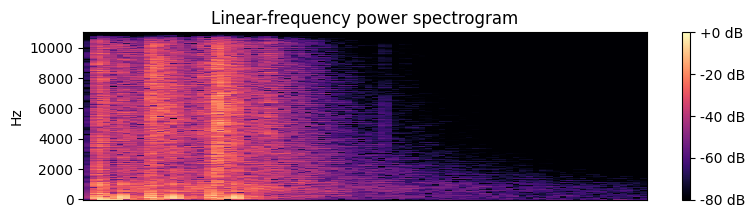

In [7]:
plt.figure(figsize=(20, 10))
D = librosa.amplitude_to_db(np.abs(librosa.stft(dat1)), ref=np.max)
plt.subplot(4, 2, 1)
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')

Text(0.5, 1.0, 'Linear-frequency power spectrogram')

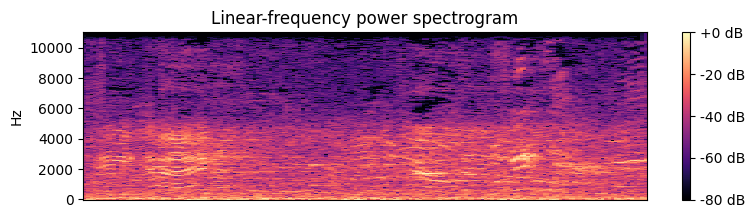

In [8]:
plt.figure(figsize=(20, 10))
D = librosa.amplitude_to_db(np.abs(librosa.stft(dat2)), ref=np.max)
plt.subplot(4, 2, 1)
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')

#### Feature Extraction
1. I have used Librosa to extract features.
2. To do so, I will go through each fold and extract the data for each file. Then I have used the mel_spectogram function of librosa to extract the spectogram data as a numpy array.
3. Classes (Y) have been converted to Categorically Encoded Data usng Keras.utils

#### Using CNN to classify sound

This is a very classical way of sound classification as it is observed that similar type of sounds have similar spectrogram (I have used melspectrogram feature extracted using librosa library). A spectrogram is a visual representation of the spectrum of frequencies of sound or other signal as they vary with time. And thus we can train a CNN network which takes these spectrogram images as input and using it tries to generalize patterns and hence classify them.

#### 10-fold cross validation using the predefined folds: 
train on data from 9 of the 10 predefined  folds and test on data from the remaining fold. Repeat this process 10 times (each time using a different set of 9 out of the 10 folds for training and the remaining fold for testing). Finally report the average classification accuracy over all 10 experiments as an average score.

In [9]:
arr = librosa.feature.melspectrogram(y=dat2, sr=sampling_rate2)
arr.shape

(128, 173)

In [10]:
def parser(row):
    # function to load files and extract features
    file_name = os.path.join('D:/Data Science/Practice/Urban Sound Classification Project Notes/UrbanSound8K/audio', 'fold'+str(row.fold), str(row.slice_file_name))
    # handle exception to check if there isn't a file which is corrupted
    try:
      # here kaiser_fast is a technique used for faster extraction
      X, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
      # We extract mfcc feature from data
      mels = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T,axis=0)        
    except Exception as e:
      print("Error encountered while parsing file: ", file_name)
      return None, None
 
    feature = mels
    label = row['class']
    fold = row['fold']
 
    return [feature, label, fold]

In [11]:
temp = df.apply(parser, axis=1)

C:\Users\Asus\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(
C:\Users\Asus\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
C:\Users\Asus\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(


In [12]:
temp_df = pd.DataFrame(temp.tolist(), columns=['feature', 'label', 'fold'])

In [13]:
temp_df.head()

,feature,label,fold
0,"[2.3283628e-05, 0.00021359067, 0.0002844038, 0...",dog_bark,5
1,"[0.049608395, 0.049436085, 0.03691951, 0.02867...",children_playing,5
2,"[0.030883819, 0.027941372, 0.036278624, 0.0257...",children_playing,5
3,"[0.026432991, 0.032280095, 0.04545298, 0.03293...",children_playing,5
4,"[0.06138195, 0.040278364, 0.02294883, 0.015539...",children_playing,5


In [14]:
input_dim = (16, 8, 1)

model = Sequential()

model.add(Conv2D(64, (3, 3), padding = "same", activation = "tanh", input_shape = input_dim))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), padding = "same", activation = "tanh"))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(1024, activation = "tanh"))
model.add(Dense(10, activation = "softmax"))

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 8, 64)         640       
                                                                 
 max_pooling2d (MaxPooling2  (None, 8, 4, 64)          0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 4, 128)         73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 4, 2, 128)         0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 4, 2, 128)         0         
                                                                 
 flatten (Flatten)           (None, 1024)              0

In [15]:
unique_folds=temp_df['fold'].unique()
mean_training_accuracy=[]
mean_validation_accuracy=[]
train_std=[]
val_std=[]

# Iterate over unique fold values
for fold_value in unique_folds:
    val = pd.DataFrame(columns=temp_df.columns)
    # Extract rows corresponding to the current fold value
    fold_rows = temp_df[temp_df['fold'] == fold_value]
    # Append the extracted rows to the removed_rows_df
    val = val.append(fold_rows, ignore_index=True)
    # Remove the rows from the original DataFrame
    train = temp_df[temp_df['fold'] != fold_value].copy()
    column_to_drop='fold'
    val.drop(columns=[column_to_drop], inplace=True)
    train.drop(columns=[column_to_drop], inplace=True)
    
    X_train = np.array(train.feature.tolist())
    X_val = np.array(val.feature.tolist())
    y_train = np.array(train.label.tolist())
    y_val = np.array(val.label.tolist())
    lb = LabelEncoder()
    y_train = to_categorical(lb.fit_transform(y_train))
    y_val = to_categorical(lb.fit_transform(y_val))

    X_train = X_train.reshape(X_train.shape[0], 16, 8, 1)
    X_val = X_val.reshape(X_val.shape[0], 16, 8, 1)

    history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_val, y_val))
    
    # Extract the training and validation accuracy from the history
    training_accuracy = history.history['accuracy']
    validation_accuracy = history.history['val_accuracy']
    # Calculate the mean accuracy
    mean_training_accuracy.append(np.mean(training_accuracy))
    mean_validation_accuracy.append(np.mean(validation_accuracy))

Epoch 1/5
244/244 [==============================] - 4s 16ms/step - loss: 1.4825 - accuracy: 0.5010 - val_loss: 1.3569 - val_accuracy: 0.5118
Epoch 2/5
244/244 [==============================] - 4s 15ms/step - loss: 1.1051 - accuracy: 0.6261 - val_loss: 1.6119 - val_accuracy: 0.4861
Epoch 3/5
244/244 [==============================] - 4s 15ms/step - loss: 0.9138 - accuracy: 0.6929 - val_loss: 1.4372 - val_accuracy: 0.5427
Epoch 4/5
244/244 [==============================] - 4s 15ms/step - loss: 0.8029 - accuracy: 0.7335 - val_loss: 1.4033 - val_accuracy: 0.5801
Epoch 5/5
244/244 [==============================] - 4s 15ms/step - loss: 0.7219 - accuracy: 0.7601 - val_loss: 1.7310 - val_accuracy: 0.5577
Epoch 1/5
247/247 [==============================] - 4s 15ms/step - loss: 0.6863 - accuracy: 0.7785 - val_loss: 0.8217 - val_accuracy: 0.7312
Epoch 2/5
247/247 [==============================] - 4s 15ms/step - loss: 0.5948 - accuracy: 0.8065 - val_loss: 1.1106 - val_accuracy: 0.6559
Epoch 

In [16]:
# Calculate mean and standard deviation of training and validation accuracies
mean_training_acc = np.mean(mean_training_accuracy)
std_training_acc = np.std(mean_training_accuracy)

mean_validation_acc = np.mean(mean_validation_accuracy)
std_validation_acc = np.std(mean_validation_accuracy)

# Report the results
print(f"Average Training Accuracy: {mean_training_acc:.2%} ± {std_training_acc:.2%}")
print(f"Average Validation Accuracy: {mean_validation_acc:.2%} ± {std_validation_acc:.2%}")

Average Training Accuracy: 89.75% ± 8.96%
Average Validation Accuracy: 83.64% ± 12.80%
